In [62]:
!pip install darts
!pip install xgboost

        waktu  DAIHATSU    HONDA  MITSUBISHI  SUZUKI   TOYOTA
0  2021-01-01    8993.0   7231.0      9108.0  6400.0  15474.0
1  2021-02-01    9412.0   6812.0      7567.0  4600.0  14645.0
2  2021-03-01   16770.0  11350.0     13088.0  8669.0  26034.0
3  2021-04-01   15861.0   8474.0     13820.0  8100.0  22618.0
4  2021-05-01    8310.0   5832.0     10160.0  5341.0  17361.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   waktu       54 non-null     object 
 1   DAIHATSU    54 non-null     float64
 2   HONDA       54 non-null     float64
 3   MITSUBISHI  54 non-null     float64
 4   SUZUKI      54 non-null     float64
 5   TOYOTA      54 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.7+ KB


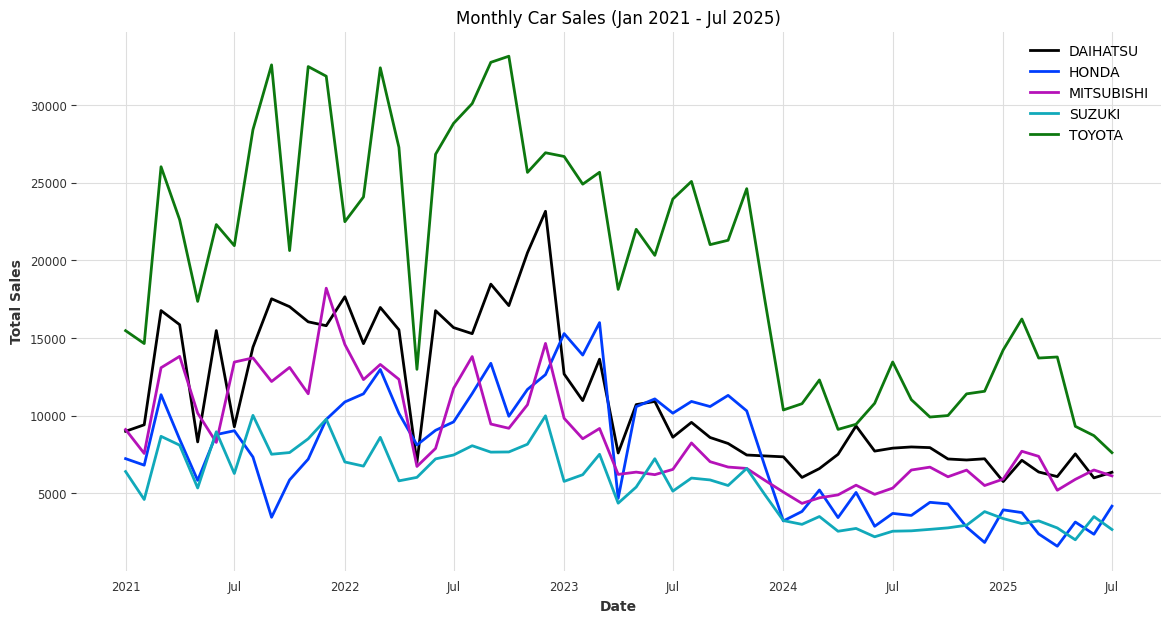

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import make_scorer

df = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/dataCarSale2021-2025.csv")
print(df.head())
df.info()

df['waktu'] = pd.to_datetime(df['waktu'])
df.set_index('waktu', inplace = True)

full_date = pd.date_range(start = df.index.min(), end = df.index.max(), freq="MS")
df = df.reindex(full_date)

df = df.interpolate(method = "linear")

series = TimeSeries.from_dataframe(df, freq='MS')

plt.figure(figsize=(14, 7))
series.plot()
plt.title('Monthly Car Sales (Jan 2021 - Jul 2025)')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [64]:
df = df.reset_index().rename(columns={'index': 'waktu'})
df = df.melt(id_vars='waktu', var_name='Brand', value_name='Sales')

df_ext = pd.read_csv("/kaggle/input/datacarsalegaikindo2021-2025/extFeat.csv")
df_ext['waktu'] = pd.to_datetime(df_ext['waktu'])
df_long = pd.merge(df, df_ext, on='waktu', how='left')

In [65]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    epsilon = 1e-9
    return np.mean(numerator / (denominator + epsilon)) * 100
    
def create_features(df):
    df_copy = df.copy()
    df_copy['month'] = df_copy['waktu'].dt.month
    df_copy['year'] = df_copy['waktu'].dt.year
    df_copy['dayofweek'] = df_copy['waktu'].dt.dayofweek
    df_copy['quarter'] = df_copy['waktu'].dt.quarter
    df_copy['dayofyear'] = df_copy['waktu'].dt.dayofyear
        
    df_copy = df_copy.sort_values(by=['Brand', 'waktu'])
    lags = [1, 2, 3, 12]
    for lag in lags:
        df_copy[f'sales_lag_{lag}'] = df_copy.groupby('Brand')['Sales'].shift(lag)
            
    window_sizes = [3, 6]
    for window in window_sizes:
        df_copy[f'sales_rolling_mean_{window}'] = df_copy.groupby('Brand')['Sales'].rolling(window=window).mean().reset_index(level=0, drop=True)
        df_copy[f'sales_rolling_std_{window}'] = df_copy.groupby('Brand')['Sales'].rolling(window=window).std().reset_index(level=0, drop=True)

    df_copy = df_copy.sort_values(by=['waktu', 'Brand'])
    return df_copy


--- Fold 1 Results ---
  - SMAPE for DAIHATSU: 5.62%
  - SMAPE for HONDA: 13.50%
  - SMAPE for MITSUBISHI: 3.27%
  - SMAPE for SUZUKI: 14.97%
  - SMAPE for TOYOTA: 5.47%
  - Overall SMAPE for Fold 1: 8.57%


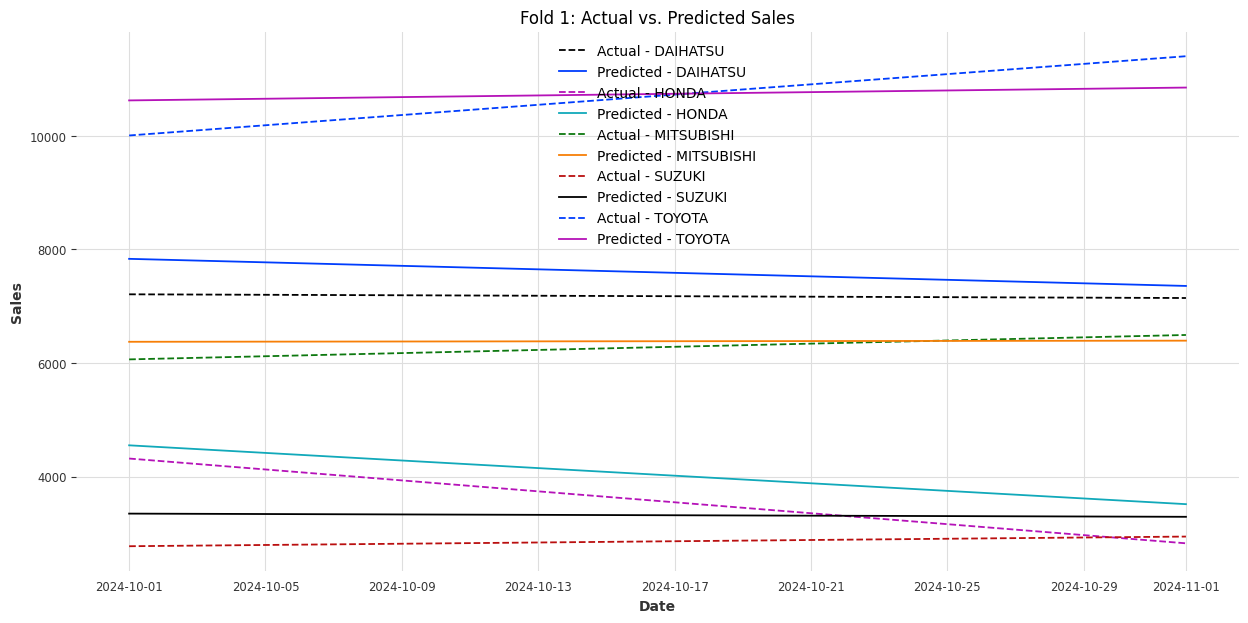


--- Fold 2 Results ---
  - SMAPE for DAIHATSU: 1.49%
  - SMAPE for HONDA: 27.56%
  - SMAPE for MITSUBISHI: 7.20%
  - SMAPE for SUZUKI: 18.24%
  - SMAPE for TOYOTA: 13.30%
  - Overall SMAPE for Fold 2: 13.56%


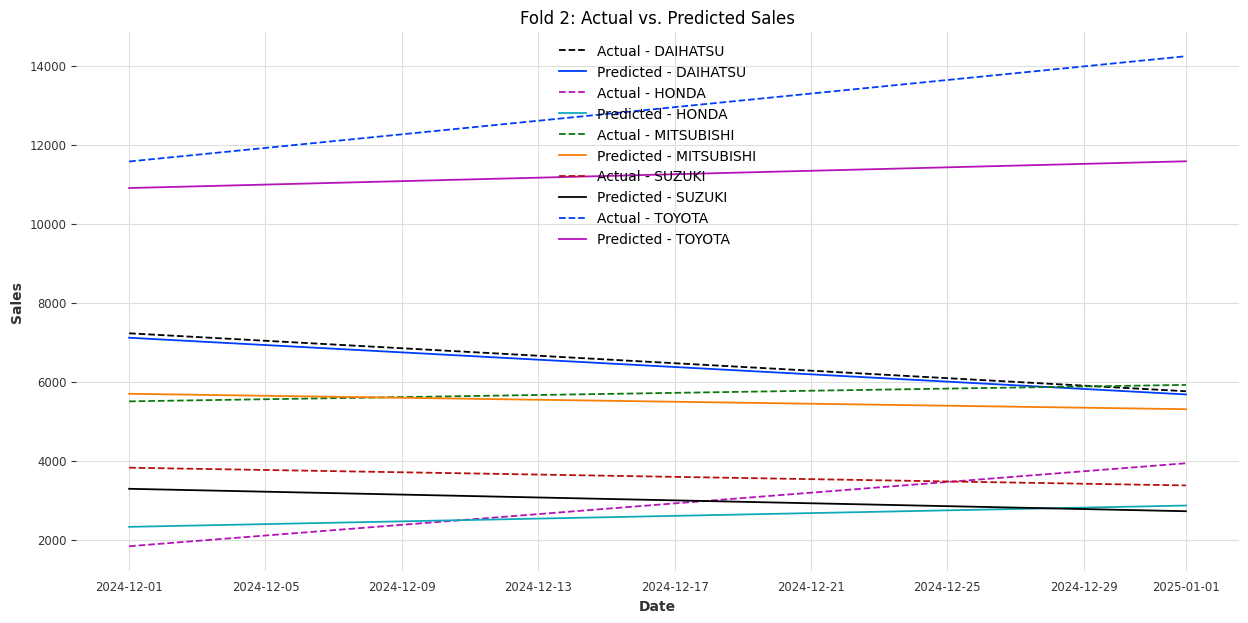


--- Fold 3 Results ---
  - SMAPE for DAIHATSU: 8.36%
  - SMAPE for HONDA: 9.43%
  - SMAPE for MITSUBISHI: 14.50%
  - SMAPE for SUZUKI: 9.78%
  - SMAPE for TOYOTA: 12.25%
  - Overall SMAPE for Fold 3: 10.86%


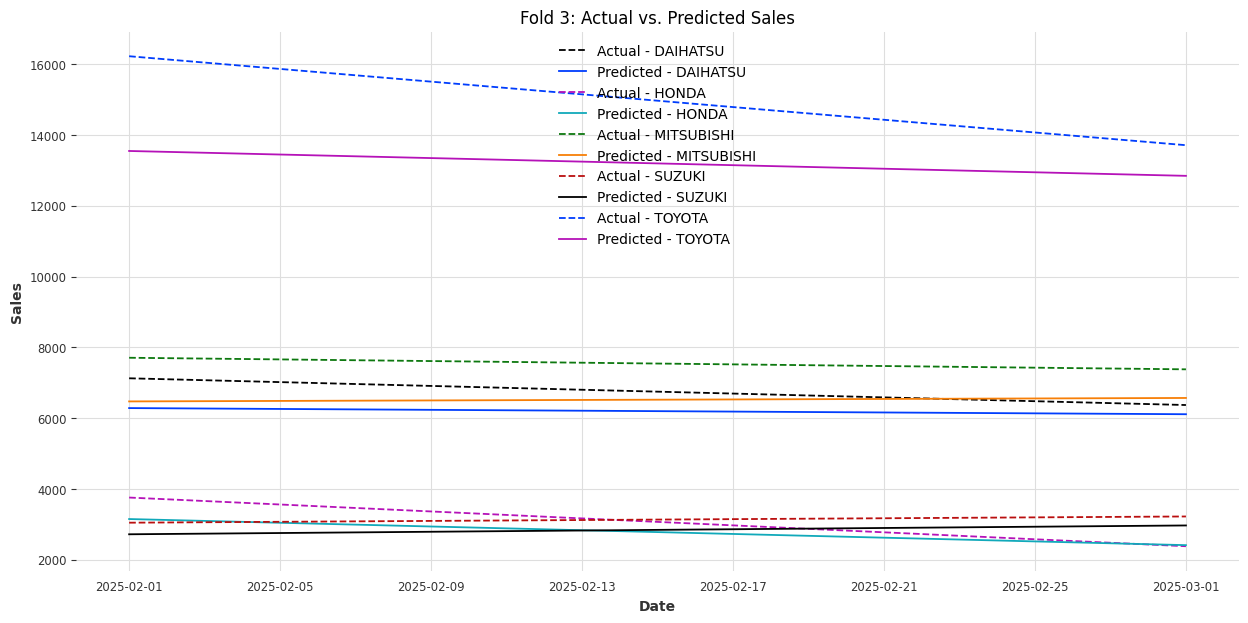


--- Fold 4 Results ---
  - SMAPE for DAIHATSU: 2.36%
  - SMAPE for HONDA: 22.59%
  - SMAPE for MITSUBISHI: 9.03%
  - SMAPE for SUZUKI: 28.71%
  - SMAPE for TOYOTA: 11.24%
  - Overall SMAPE for Fold 4: 14.79%


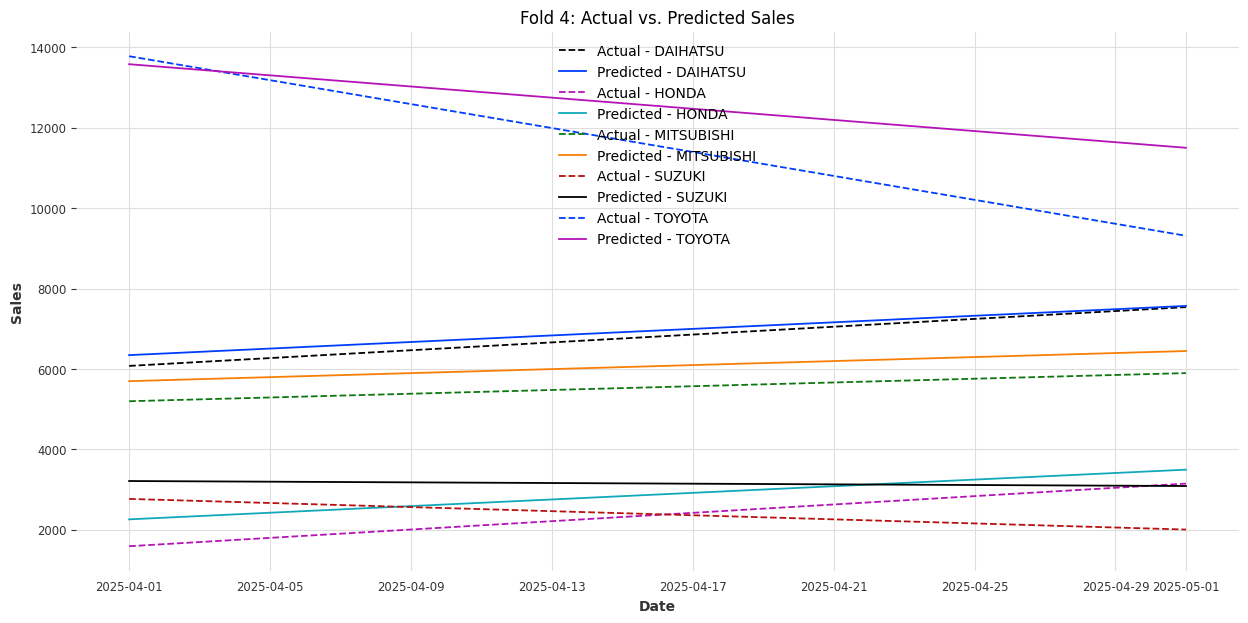


--- Fold 5 Results ---
  - SMAPE for DAIHATSU: 4.44%
  - SMAPE for HONDA: 12.71%
  - SMAPE for MITSUBISHI: 4.74%
  - SMAPE for SUZUKI: 13.18%
  - SMAPE for TOYOTA: 12.23%
  - Overall SMAPE for Fold 5: 9.46%


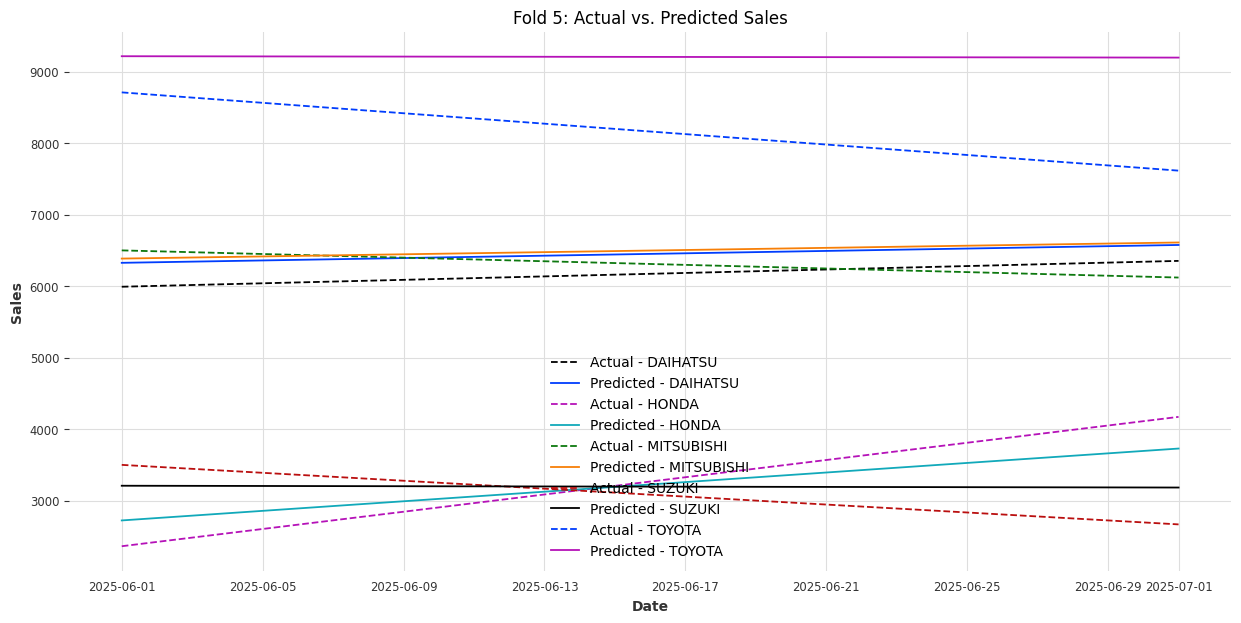

Average SMAPE for DAIHATSU: 4.45%
Average SMAPE for HONDA: 17.16%
Average SMAPE for MITSUBISHI: 7.75%
Average SMAPE for SUZUKI: 16.97%
Average SMAPE for TOYOTA: 10.90%

Overall Average SMAPE for Ensemble Model: 11.45%


In [66]:
FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen'
]
TARGET = 'Sales'

df_long = df_long.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=10)

brand_scores = {brand: [] for brand in df_long['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_long):
    train_fold = df_long.iloc[train_index].copy()
    test_fold = df_long.iloc[test_index].copy()

    train_featured = create_features(train_fold)
    train_final = train_featured.dropna()

    # LightGBM
    lgbm_features = FEATURES + ['Brand']
    X_train_lgbm = train_final[lgbm_features].copy()
    y_train_lgbm = train_final[TARGET]
    X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')
    
    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train_lgbm, y_train_lgbm)
    
    # Ridge
    train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
    brand_cols = [c for c in train_encoded if 'Brand_' in c]
    ridge_features = FEATURES + brand_cols
    X_train_ridge = train_encoded[ridge_features]
    y_train_ridge = train_encoded[TARGET]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_ridge)
    ridge = Ridge(random_state=42)
    ridge.fit(X_train_scaled, y_train_ridge)

    history = train_fold.copy()
    predictions = []

    for i in range(len(test_fold)):
        current_step_df = test_fold.iloc[[i]]

        feature_creation_df = pd.concat([history, current_step_df])
        features_for_pred = create_features(feature_creation_df).iloc[-1:]

        # LightGBM
        X_test_lgbm_step = features_for_pred[lgbm_features].copy()
        X_test_lgbm_step['Brand'] = X_test_lgbm_step['Brand'].astype('category')
        pred_lgbm_step = lgbm.predict(X_test_lgbm_step)[0]

        # Ridge
        test_encoded_step = pd.get_dummies(features_for_pred, columns=['Brand'], drop_first=True)
        test_encoded_step = test_encoded_step.reindex(columns=X_train_ridge.columns, fill_value=0)
        X_test_ridge_step = test_encoded_step[ridge_features]
        X_test_scaled_step = scaler.transform(X_test_ridge_step)
        pred_ridge_step = ridge.predict(X_test_scaled_step)[0]
    
        # Ensemble & Evaluation
        ensemble_pred = 0.8 * pred_ridge_step + 0.2 * pred_lgbm_step
        predictions.append(ensemble_pred)

        history = pd.concat([history, current_step_df])

    results_df = test_fold.copy()
    results_df['Predictions'] = predictions
    
    print(f"\n--- Fold {fold_number} Results ---")
    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Sales'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Sales'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
    # Visualization
    plt.figure(figsize=(15, 7))
    for brand in results_df['Brand'].unique():
        plot_df = results_df[results_df['Brand'] == brand]
        plt.plot(plot_df['waktu'], plot_df['Sales'], '--', label=f'Actual - {brand}')
        plt.plot(plot_df['waktu'], plot_df['Predictions'], '-', label=f'Predicted - {brand}')
    
    plt.title(f'Fold {fold_number}: Actual vs. Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

print(f"\nOverall Average SMAPE for Ensemble Model: {np.mean(overall_scores):.2f}%")


--- Fold 1 Results ---
  - SMAPE for DAIHATSU: 5.62%
  - SMAPE for HONDA: 13.50%
  - SMAPE for MITSUBISHI: 3.27%
  - SMAPE for SUZUKI: 14.97%
  - SMAPE for TOYOTA: 5.47%
  - Overall SMAPE for Fold 1: 8.57%


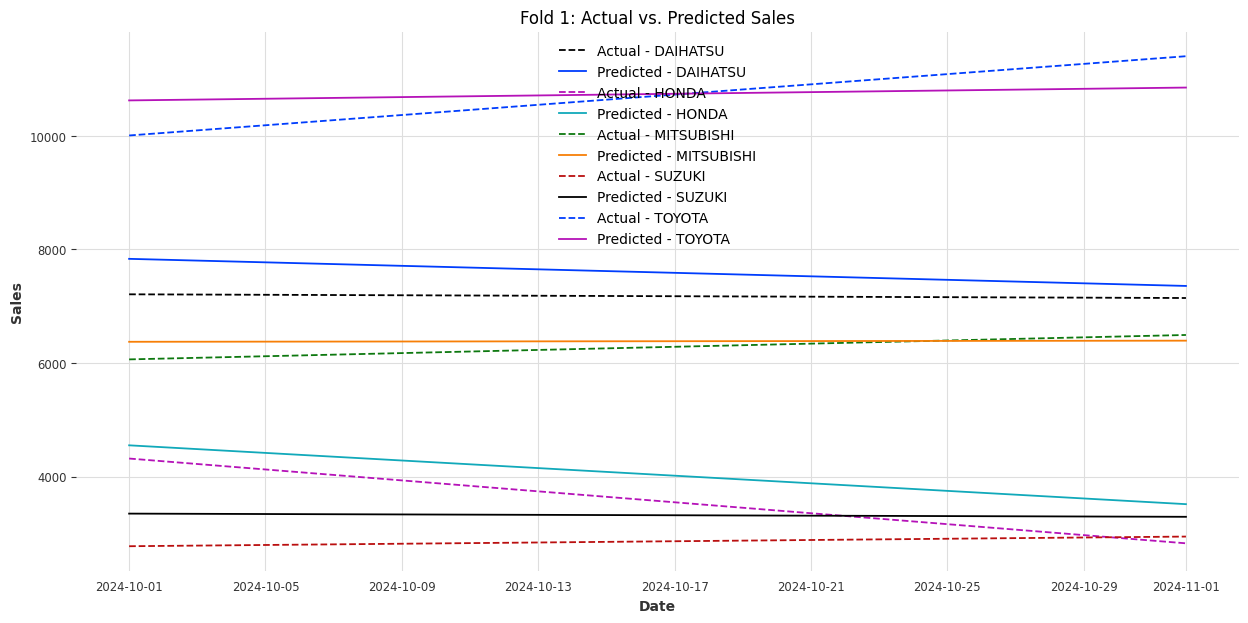


--- Fold 2 Results ---
  - SMAPE for DAIHATSU: 1.49%
  - SMAPE for HONDA: 27.56%
  - SMAPE for MITSUBISHI: 7.20%
  - SMAPE for SUZUKI: 18.24%
  - SMAPE for TOYOTA: 13.30%
  - Overall SMAPE for Fold 2: 13.56%


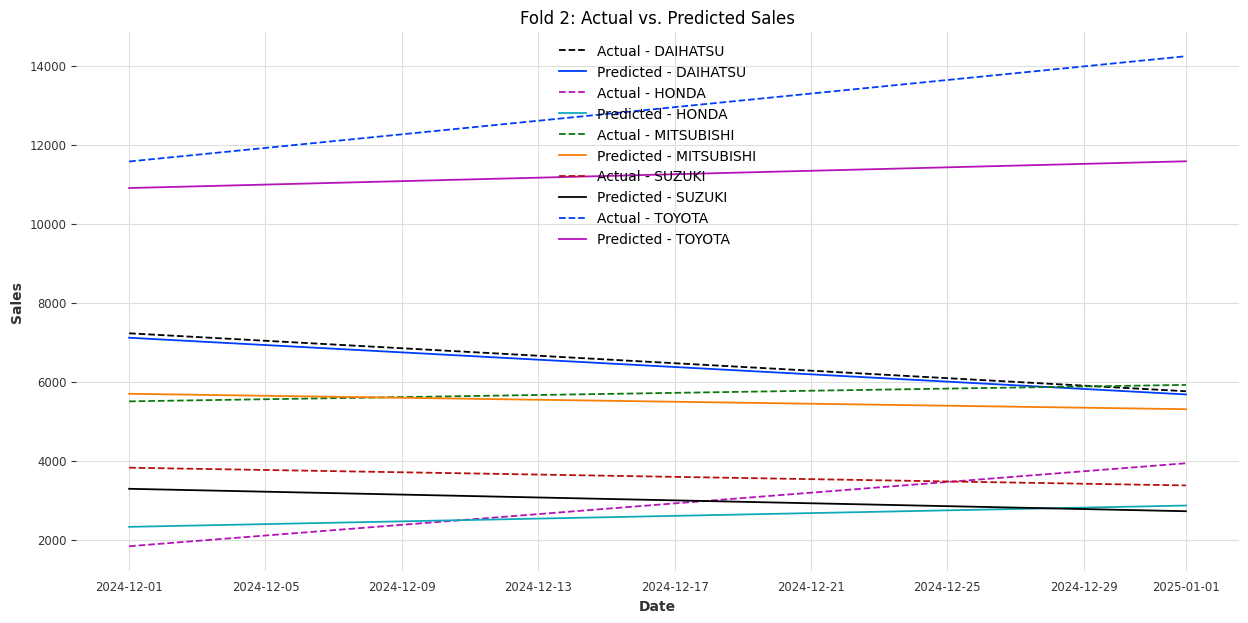


--- Fold 3 Results ---
  - SMAPE for DAIHATSU: 8.36%
  - SMAPE for HONDA: 9.43%
  - SMAPE for MITSUBISHI: 14.50%
  - SMAPE for SUZUKI: 9.78%
  - SMAPE for TOYOTA: 12.25%
  - Overall SMAPE for Fold 3: 10.86%


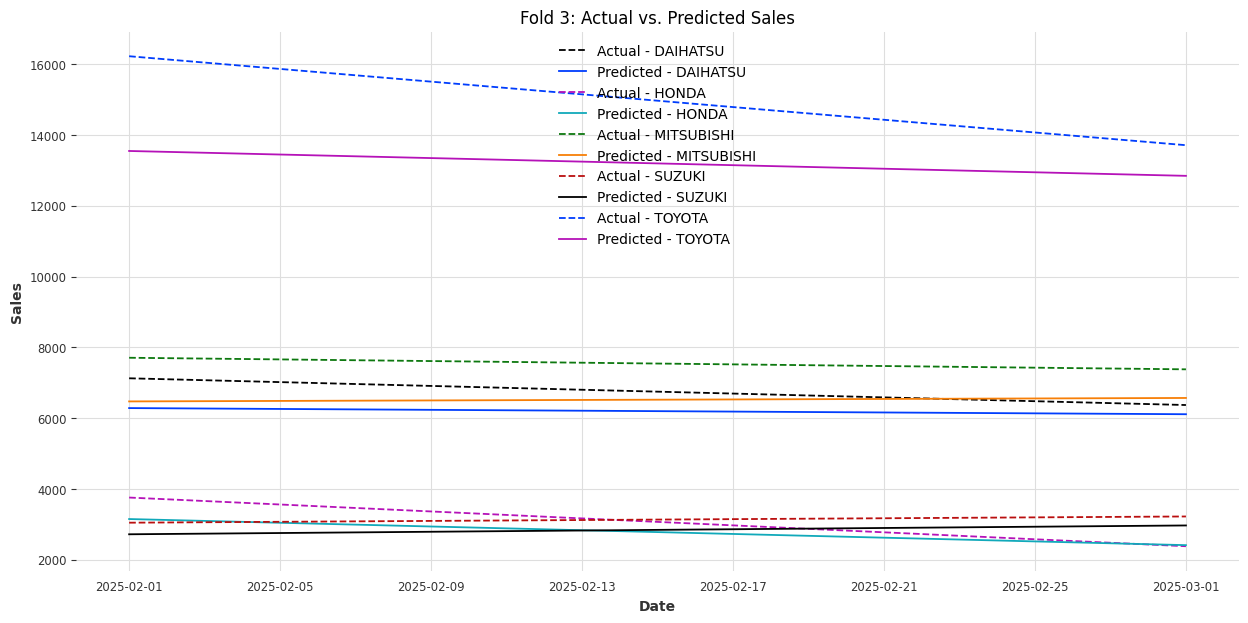


--- Fold 4 Results ---
  - SMAPE for DAIHATSU: 2.36%
  - SMAPE for HONDA: 22.59%
  - SMAPE for MITSUBISHI: 9.03%
  - SMAPE for SUZUKI: 28.71%
  - SMAPE for TOYOTA: 11.24%
  - Overall SMAPE for Fold 4: 14.79%


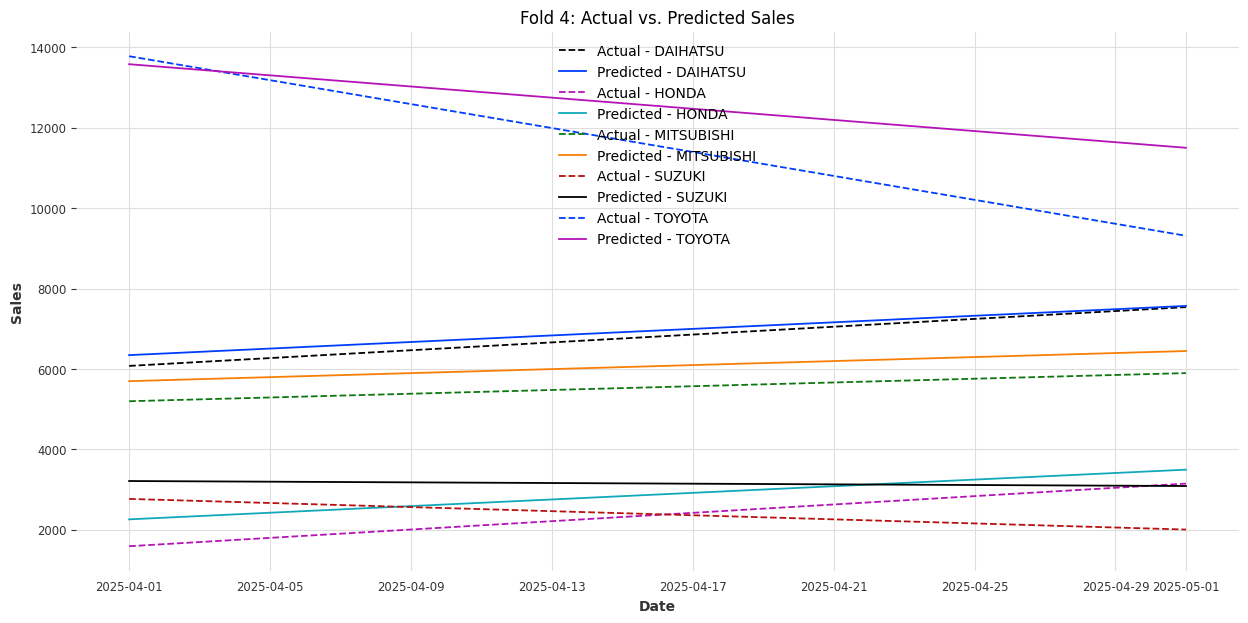


--- Fold 5 Results ---
  - SMAPE for DAIHATSU: 4.44%
  - SMAPE for HONDA: 12.71%
  - SMAPE for MITSUBISHI: 4.74%
  - SMAPE for SUZUKI: 13.18%
  - SMAPE for TOYOTA: 12.23%
  - Overall SMAPE for Fold 5: 9.46%


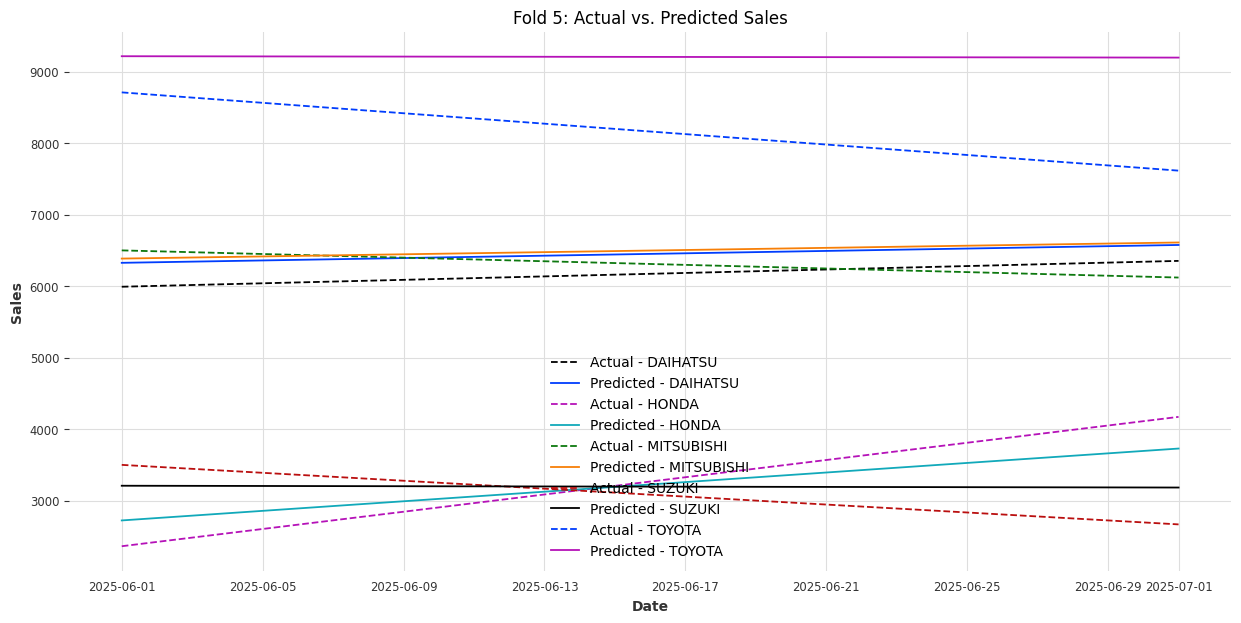

Average SMAPE for DAIHATSU: 4.45%
Average SMAPE for HONDA: 17.16%
Average SMAPE for MITSUBISHI: 7.75%
Average SMAPE for SUZUKI: 16.97%
Average SMAPE for TOYOTA: 10.90%

Overall Average SMAPE for Ensemble Model: 11.45%


In [67]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

FEATURES = [
    'month', 'year', 'dayofweek', 'quarter', 'dayofyear',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
    'sales_rolling_mean_3', 'sales_rolling_std_3',
    'sales_rolling_mean_6', 'sales_rolling_std_6',
    'bi_rate', 'IKK', 'inflasi_bulanan', 'ritel_yoy', 'kredit_konsumen'
]
TARGET = 'Sales'

df_long = df_long.sort_values(by=['waktu', 'Brand'])

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=10)

brand_scores = {brand: [] for brand in df_long['Brand'].unique()}
overall_scores = []
fold_number = 1

for train_index, test_index in tscv.split(df_long):
    train_fold = df_long.iloc[train_index].copy()
    test_fold = df_long.iloc[test_index].copy()

    train_featured = create_features(train_fold)
    train_final = train_featured.dropna()

    # LightGBM
    lgbm_features = FEATURES + ['Brand']
    X_train_lgbm = train_final[lgbm_features].copy()
    y_train_lgbm = train_final[TARGET]
    X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')
    
    lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
    lgbm.fit(X_train_lgbm, y_train_lgbm)
    
    # XGBoost
    xgb_features = FEATURES + ['Brand']
    X_train_xgb = train_final[xgb_features].copy()
    y_train_xgb = train_final[TARGET]
    X_train_xgb['Brand'] = X_train_xgb['Brand'].astype('category')

    xgb = XGBRegressor(random_state=42, enable_categorical=True) 
    xgb.fit(X_train_xgb, y_train_xgb)

    # Ridge
    train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
    brand_cols = [c for c in train_encoded if 'Brand_' in c]
    ridge_features = FEATURES + brand_cols
    X_train_ridge = train_encoded[ridge_features]
    y_train_ridge = train_encoded[TARGET]
    
    scaler_ridge = StandardScaler()
    X_train_scaled = scaler_ridge.fit_transform(X_train_ridge)
    ridge = Ridge(random_state=42)
    ridge.fit(X_train_scaled, y_train_ridge)

    # Lasso
    train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
    brand_cols = [c for c in train_encoded if 'Brand_' in c]
    lasso_features = FEATURES + brand_cols
    X_train_lasso = train_encoded[lasso_features]
    y_train_lasso = train_encoded[TARGET]
        
    scaler_lasso = StandardScaler()
    X_train_scaled = scaler_lasso.fit_transform(X_train_lasso)
    lasso_final = Lasso(random_state=42)
    lasso_final.fit(X_train_scaled, y_train_lasso)

    history = train_fold.copy()
    predictions = []

    for i in range(len(test_fold)):
        current_step_df = test_fold.iloc[[i]]

        feature_creation_df = pd.concat([history, current_step_df])
        features_for_pred = create_features(feature_creation_df).iloc[-1:]

        # LightGBM
        X_test_lgbm_step = features_for_pred[lgbm_features].copy()
        X_test_lgbm_step['Brand'] = X_test_lgbm_step['Brand'].astype('category')
        pred_lgbm_step = lgbm.predict(X_test_lgbm_step)[0]
        
        # XGBoost
        X_test_xgb_step = features_for_pred[xgb_features].copy()
        X_test_xgb_step['Brand'] = X_test_xgb_step['Brand'].astype('category')
        pred_xgb_step = xgb.predict(X_test_xgb_step)[0]

        # Ridge
        test_encoded_step = pd.get_dummies(features_for_pred, columns=['Brand'], drop_first=True)
        test_encoded_step = test_encoded_step.reindex(columns=X_train_ridge.columns, fill_value=0)
        X_test_ridge_step = test_encoded_step[ridge_features]
        X_test_scaled_step = scaler_ridge.transform(X_test_ridge_step)
        pred_ridge_step = ridge.predict(X_test_scaled_step)[0]
        
        # Lasso
        test_encoded_step = pd.get_dummies(features_for_pred, columns=['Brand'], drop_first=True)
        test_encoded_step = test_encoded_step.reindex(columns=X_train_lasso.columns, fill_value=0)
        X_test_lasso_step = test_encoded_step[lasso_features]
        X_test_scaled_step = scaler_lasso.transform(X_test_lasso_step)
        pred_lasso_step = lasso_final.predict(X_test_scaled_step)[0]

        ensemble_pred = 0.8 * pred_ridge_step + 0.2 * pred_lgbm_step
        # ensemble_pred = 0.8 * pred_ridge_step + 0.2 * pred_xgb_step
        # ensemble_pred = 0.8 * pred_lasso_step + 0.2 * pred_lgbm_step
        # ensemble_pred = 0.8 * pred_lasso_step + 0.2 * pred_xgb_step
        # predictions.append(pred_ridge_step)
        # predictions.append(pred_lasso_step)
        # predictions.append(pred_lgbm_step)
        # predictions.append(pred_xgb_step)
        predictions.append(ensemble_pred)

        history = pd.concat([history, current_step_df])

    results_df = test_fold.copy()
    results_df['Predictions'] = predictions
    
    print(f"\n--- Fold {fold_number} Results ---")
    for brand_name in results_df['Brand'].unique():
        brand_df = results_df[results_df['Brand'] == brand_name]
        brand_smape = smape(brand_df['Sales'], brand_df['Predictions'])
        brand_scores[brand_name].append(brand_smape)
        print(f"  - SMAPE for {brand_name}: {brand_smape:.2f}%")
    
    overall_fold_score = smape(results_df['Sales'], results_df['Predictions'])
    overall_scores.append(overall_fold_score)
    print(f"  - Overall SMAPE for Fold {fold_number}: {overall_fold_score:.2f}%")
    
    # Visualization
    plt.figure(figsize=(15, 7))
    for brand in results_df['Brand'].unique():
        plot_df = results_df[results_df['Brand'] == brand]
        plt.plot(plot_df['waktu'], plot_df['Sales'], '--', label=f'Actual - {brand}')
        plt.plot(plot_df['waktu'], plot_df['Predictions'], '-', label=f'Predicted - {brand}')
    
    plt.title(f'Fold {fold_number}: Actual vs. Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    fold_number += 1

for brand_name, scores in brand_scores.items():
    print(f"Average SMAPE for {brand_name}: {np.mean(scores):.2f}%")

print(f"\nOverall Average SMAPE for Ensemble Model: {np.mean(overall_scores):.2f}%")

In [68]:
train_df = df_long[df_long['waktu'] < '2025-07-01'].copy()
future_df = df_long[df_long['waktu'] == '2025-07-01'].copy()

unk_cols = ['bi_rate', 'IKK', 'ritel_yoy', 'inflasi_bulanan', 'kredit_konsumen']
future_df['Sales'] = np.nan
future_df[unk_cols] = np.nan

train_final = create_features(train_df).dropna()

# LightGBM
lgbm_features = FEATURES + ['Brand']
X_train_lgbm = train_final[lgbm_features].copy()
y_train_lgbm = train_final[TARGET]
X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')

lgbm_final = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_final.fit(X_train_lgbm, y_train_lgbm)

# XGBoost
xgb_features = FEATURES + ['Brand']
X_train_xgb = train_final[xgb_features].copy()
y_train_xgb = train_final[TARGET]
X_train_xgb['Brand'] = X_train_xgb['Brand'].astype('category')

xgb_final = XGBRegressor(random_state=42, enable_categorical=True) 
xgb_final.fit(X_train_xgb, y_train_xgb)

# Ridge
train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
brand_cols = [c for c in train_encoded if 'Brand_' in c]
ridge_features = FEATURES + brand_cols
X_train_ridge = train_encoded[ridge_features]
y_train_ridge = train_encoded[TARGET]

scaler_final_ridge = StandardScaler()
X_train_scaled = scaler_final_ridge.fit_transform(X_train_ridge)
ridge_final = Ridge(random_state=42)
ridge_final.fit(X_train_scaled, y_train_ridge)

# Lasso
train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
brand_cols = [c for c in train_encoded if 'Brand_' in c]
lasso_features = FEATURES + brand_cols
X_train_lasso = train_encoded[lasso_features]
y_train_lasso = train_encoded[TARGET]
        
scaler_final_lasso = StandardScaler()
X_train_scaled = scaler_final_lasso.fit_transform(X_train_lasso)
lasso_final = Lasso(random_state=42)
lasso_final.fit(X_train_scaled, y_train_lasso)

X_pred = pd.DataFrame()

for brand in df_long['Brand'].unique():
    history_brand = train_df[train_df['Brand'] == brand].copy()
    future_brand = future_df[future_df['Brand'] == brand].copy()

    future_brand['month'] = future_brand['waktu'].dt.month
    future_brand['year'] = future_brand['waktu'].dt.year
    future_brand['dayofweek'] = future_brand['waktu'].dt.dayofweek
    future_brand['quarter'] = future_brand['waktu'].dt.quarter
    future_brand['dayofyear'] = future_brand['waktu'].dt.dayofyear    

    last_known_ext = history_brand[unk_cols].iloc[-1]
    future_brand[unk_cols] = last_known_ext.values

    lags = [1, 2, 3, 12]
    for lag in lags:
        future_brand[f'sales_lag_{lag}'] = history_brand['Sales'].iloc[-lag]

    window_sizes = [3, 6]
    for window in window_sizes:
        history_slice = history_brand['Sales'].iloc[-(window-1):]
        future_brand[f'sales_rolling_mean_{window}'] = history_slice.mean()
        future_brand[f'sales_rolling_std_{window}'] = history_slice.std()

    X_pred = pd.concat([X_pred, future_brand])

X_pred = X_pred.sort_values(by=['waktu', 'Brand'])

# LightGBM
X_pred_lgbm = X_pred[lgbm_features].copy()
X_pred_lgbm['Brand'] = X_pred_lgbm['Brand'].astype('category')
preds_lgbm = lgbm_final.predict(X_pred_lgbm)

# XGBoost
X_pred_xgb = X_pred[xgb_features].copy()
X_pred_xgb['Brand'] = X_pred_xgb['Brand'].astype('category')
preds_xgb = xgb_final.predict(X_pred_xgb)

# Ridge
pred_encoded_ridge = pd.get_dummies(X_pred, columns=['Brand'], drop_first=True)
pred_encoded_ridge = pred_encoded_ridge.reindex(columns=X_train_ridge.columns, fill_value=0)
X_pred_ridge = pred_encoded_ridge[ridge_features]
X_pred_scaled = scaler_final_ridge.transform(X_pred_ridge)
preds_ridge = ridge_final.predict(X_pred_scaled)

# Lasso
pred_encoded_lasso = pd.get_dummies(X_pred, columns=['Brand'], drop_first=True)
pred_encoded_lasso = pred_encoded_lasso.reindex(columns=X_train_lasso.columns, fill_value=0)
X_pred_lasso = pred_encoded_lasso[lasso_features]
X_pred_scaled = scaler_final_lasso.transform(X_pred_lasso)
preds_lasso = lasso_final.predict(X_pred_scaled)

# final_predictions = preds_lgbm
# final_predictions = preds_xgb
# final_predictions = preds_ridge
# final_predictions = preds_lasso
final_predictions = 0.8 * preds_ridge + 0.2 * preds_lgbm
# final_predictions = 0.8 * preds_lasso + 0.2 * preds_lgbm
# final_predictions = 0.8 * preds_ridge + 0.2 * preds_xgb
# final_predictions = 0.8 * preds_lasso + 0.2 * preds_xgb

prediction_df = X_pred[['waktu', 'Brand']].copy()
prediction_df['Predicted_Sales'] = final_predictions

print("## Final Predictions for July 2025 ##")
print(prediction_df)


## Final Predictions for July 2025 ##
         waktu       Brand  Predicted_Sales
54  2025-07-01    DAIHATSU      6733.660480
109 2025-07-01       HONDA      3001.196588
164 2025-07-01  MITSUBISHI      6494.091794
219 2025-07-01      SUZUKI      3003.824015
274 2025-07-01      TOYOTA     10498.301660


In [69]:
# JULY TEST RESULTS #
# This is the actual:
# DAIHATSU: 6354.101
# HONDA: 4171.007
# MITSUBISHI: 6121.0
# SUZUKI: 2666.235
# TOYOTA: 7617.122

# LightGBM Prediction
# DAIHATSU SMAPE: 0.12% (BEST DAIHATSU SCORE)
# HONDA SMAPE: 39.91%
# MITSUBISHI SMAPE: 2.34%
# SUZUKI SMAPE: 5.07%
# TOYOTA SMAPE: 29.15%
# Overall Average SMAPE: 15.32%

# XGBoost Prediction
# DAIHATSU SMAPE: 9.35%
# HONDA SMAPE: 47.41%
# MITSUBISHI SMAPE: 3.86%
# SUZUKI SMAPE: 7.86%
# TOYOTA SMAPE: 18.86%
# Overall Average SMAPE: 17.47%

# Ridge Prediction
# (Most consistent scores across all brands/Not fluctuative)
# DAIHATSU SMAPE: 7.17%
# HONDA SMAPE: 30.86% (BEST HONDA SCORE)
# MITSUBISHI SMAPE: 7.88%
# SUZUKI SMAPE: 13.54%
# TOYOTA SMAPE: 32.46%
# Overall Average SMAPE: 18.38%

# Lasso Prediction
# DAIHATSU SMAPE: 6.26%
# HONDA SMAPE: 40.78%
# MITSUBISHI SMAPE: 1.37%
# SUZUKI SMAPE: 3.45%
# TOYOTA SMAPE: 16.96% (BEST TOYOTA SCORE)
# Overall Average SMAPE: 13.76%

# LightGBM + Ridge Prediction
# (2nd Most consistent scores)
# DAIHATSU SMAPE: 5.80%
# HONDA SMAPE: 32.62%
# MITSUBISHI SMAPE: 5.92%
# SUZUKI SMAPE: 11.91%
# TOYOTA SMAPE: 31.81%
# Overall Average SMAPE: 17.61%

# LightGBM + Lasso Prediction
# DAIHATSU SMAPE: 5.06%
# HONDA SMAPE: 40.60%
# MITSUBISHI SMAPE: 0.64% (BEST MITSUBISHI SCORE)
# SUZUKI SMAPE: 3.77%
# TOYOTA SMAPE: 19.53%
# Overall Average SMAPE: 13.92%

# XGBoost + Ridge Prediction
# DAIHATSU SMAPE: 4.08%
# HONDA SMAPE: 34.06%
# MITSUBISHI SMAPE: 7.09%
# SUZUKI SMAPE: 9.62%
# TOYOTA SMAPE: 29.95%
# Overall Average SMAPE: 16.96%

# XGBoost + Lasso Prediction
# DAIHATSU SMAPE: 3.33%
# HONDA SMAPE: 42.14%
# MITSUBISHI SMAPE: 1.87%
# SUZUKI SMAPE: 1.28% (BEST SUZUKI SCORE)
# TOYOTA SMAPE: 17.39%
# Overall Average SMAPE: 13.2% (BEST OVERALL SCORE)

In [70]:
train_df = df_long[df_long['waktu'] < '2025-08-01'].copy()

predict_date = pd.to_datetime('2025-08-01')
brands_to_predict = df_long['Brand'].unique()
future_df = pd.DataFrame({
    'waktu': [predict_date] * len(brands_to_predict),
    'Brand': brands_to_predict,
    'Sales': np.nan
})

unk_cols = ['bi_rate', 'IKK', 'ritel_yoy', 'inflasi_bulanan', 'kredit_konsumen']
for col in unk_cols:
    future_df[col] = np.nan

train_final = create_features(train_df).dropna()

# LightGBM
lgbm_features = FEATURES + ['Brand']
X_train_lgbm = train_final[lgbm_features].copy()
y_train_lgbm = train_final[TARGET]
X_train_lgbm['Brand'] = X_train_lgbm['Brand'].astype('category')

lgbm_final = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_final.fit(X_train_lgbm, y_train_lgbm)

# Ridge
train_encoded = pd.get_dummies(train_final, columns=['Brand'], drop_first=True)
brand_cols = [c for c in train_encoded if 'Brand_' in c]
ridge_features = FEATURES + brand_cols
X_train_ridge = train_encoded[ridge_features]
y_train_ridge = train_encoded[TARGET]

scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_ridge)
ridge_final = Ridge(random_state=42)
ridge_final.fit(X_train_scaled, y_train_ridge)

X_pred = pd.DataFrame()

for brand in df_long['Brand'].unique():
    history_brand = train_df[train_df['Brand'] == brand].copy()
    future_brand = future_df[future_df['Brand'] == brand].copy()

    future_brand['month'] = future_brand['waktu'].dt.month
    future_brand['year'] = future_brand['waktu'].dt.year
    future_brand['dayofweek'] = future_brand['waktu'].dt.dayofweek
    future_brand['quarter'] = future_brand['waktu'].dt.quarter
    future_brand['dayofyear'] = future_brand['waktu'].dt.dayofyear    

    last_known_ext = history_brand[unk_cols].iloc[-1]
    future_brand[unk_cols] = last_known_ext.values
    future_brand['inflasi_bulanan'] = -0.08

    lags = [1, 2, 3, 12]
    for lag in lags:
        future_brand[f'sales_lag_{lag}'] = history_brand['Sales'].iloc[-lag]

    window_sizes = [3, 6]
    for window in window_sizes:
        history_slice = history_brand['Sales'].iloc[-(window-1):]
        future_brand[f'sales_rolling_mean_{window}'] = history_slice.mean()
        future_brand[f'sales_rolling_std_{window}'] = history_slice.std()

    X_pred = pd.concat([X_pred, future_brand])

X_pred = X_pred.sort_values(by=['waktu', 'Brand'])

# LightGBM
X_pred_lgbm = X_pred[lgbm_features].copy()
X_pred_lgbm['Brand'] = X_pred_lgbm['Brand'].astype('category')
preds_lgbm = lgbm_final.predict(X_pred_lgbm)

# Ridge
pred_encoded = pd.get_dummies(X_pred, columns=['Brand'], drop_first=True)
pred_encoded = pred_encoded.reindex(columns=X_train_ridge.columns, fill_value=0)
X_pred_ridge = pred_encoded[ridge_features]
X_pred_scaled = scaler_final.transform(X_pred_ridge)
preds_ridge = ridge_final.predict(X_pred_scaled)

final_predictions = 0.8 * preds_ridge + 0.2 * preds_lgbm

prediction_df = X_pred[['waktu', 'Brand']].copy()
prediction_df['Predicted_Sales'] = final_predictions

print("## Final Predictions for August 2025 ##")
print(prediction_df)

## Final Predictions for August 2025 ##
       waktu       Brand  Predicted_Sales
0 2025-08-01    DAIHATSU      6569.287163
1 2025-08-01       HONDA      3381.295579
2 2025-08-01  MITSUBISHI      6494.155804
3 2025-08-01      SUZUKI      3031.087547
4 2025-08-01      TOYOTA      8869.585205
